In [40]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json
import requests
import urllib.request
from tqdm import tqdm
# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import nibabel as nib

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image
from scipy.io import loadmat

def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)

from nilearn import image
from nilearn.plotting import plot_prob_atlas
%matplotlib inline
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from nilearn.decomposition import CanICA

#Make function for everything 

def spatial_ICA(func_path, anat_path, ica_comp, pca = True, pca_comp = None,  axial_plots = True, other_plots = False): 

    img = nib.load(func_path)
    affine = img.affine
    fdata = img.get_fdata()
    x, y, z, N_vol = fdata.shape
    display("Got fdata of dimensions =", x, y, z, N_vol)
    
    X_ = fdata.reshape(-1, fdata.shape[-1])
    X = X_.T
    display("X shape =", X.shape)
    
    T1w_img = nib.load(anat_path)
    
    icbms = datasets.fetch_icbm152_2009()
    masker = NiftiMasker(mask_img=icbms.mask)
    plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)
    
    S_dict = {}

    nb_components =  [ica_comp,]#10]#20, 60 ...]
    
    
    for n in nb_components:

        if (pca):
            print(f"Processing component {n}")
            # run PCA as a preprocessing step for ICA with twice the number of components
            n2=2*n

            if (pca_comp is not None):
                n2 = pca_comp
            pca = PCA(n_components=n2)
            H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
            display(pca.explained_variance_ratio_, "Explained Variance = ", np.sum(pca.explained_variance_ratio_))
        else:
            H = X.T
        
        display("Running FastICA with n = %d components" %n)

        ica = FastICA(n_components=n, random_state=1, max_iter=200)
        display("size H", H.shape)
        S_ = ica.fit_transform(H)  # Get the estimated sources (S)
        display("size S", S_.shape)
        print(S_.shape)
        W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
        S_dict[n] = S_ # store the results in a dictionary
    
    display("Done ICA")

    if (axial_plots):
        for n in nb_components:
            print('Number of components: ', n)
            S_ = S_dict[n].copy()
            for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
                s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
                data = masker.fit_transform(s_img)
                masked_ = masker.inverse_transform(data) #mask the components
                plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                              colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                              #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
                plt.show()

    if (other_plots):
        #* Plot the group-level independent components for the different number of requested components.
        for n in nb_components:
            print('Number of components: ', n)
            S_ = S_dict[n].copy()
            for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
                s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
                data = masker.fit_transform(s_img)
                masked_ = masker.inverse_transform(data) # mask the components
                plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                              colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                              #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
                plt.show()
    display("Done all")
    return 0   

# MINI PROJECT 2
## Variant 3

In [34]:
bids_root = op.join(os.path.abspath(""))
print(bids_root)

func_name = f"sub-04_task-watchmovie_bold.nii.gz"
anat_name = "sub-04_T1w.nii.gz"

### 1. Briefly describe the dataset and the scientific question you want to answer.

### 2.

### 3. Vary the number of components you are considering and visualise the spatial maps. Check if you are able to find meaningful maps according to the question you asked or the type of the dataset. You can also look at the atlas to have hints on the brain regions of interest.

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

array([9.99968829e-01, 3.39776795e-06, 1.76236724e-06, 1.56847129e-06,
       1.40762376e-06, 1.06679639e-06, 9.97099162e-07, 8.92372301e-07])

'Explained Variance = '

0.9999799218617106

'Running FastICA with n = 4 components'

'size H'

(271633, 8)

'size S'

(271633, 4)

'Done ICA'

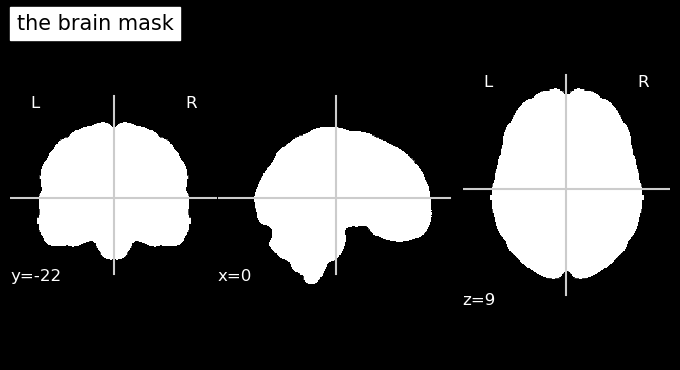

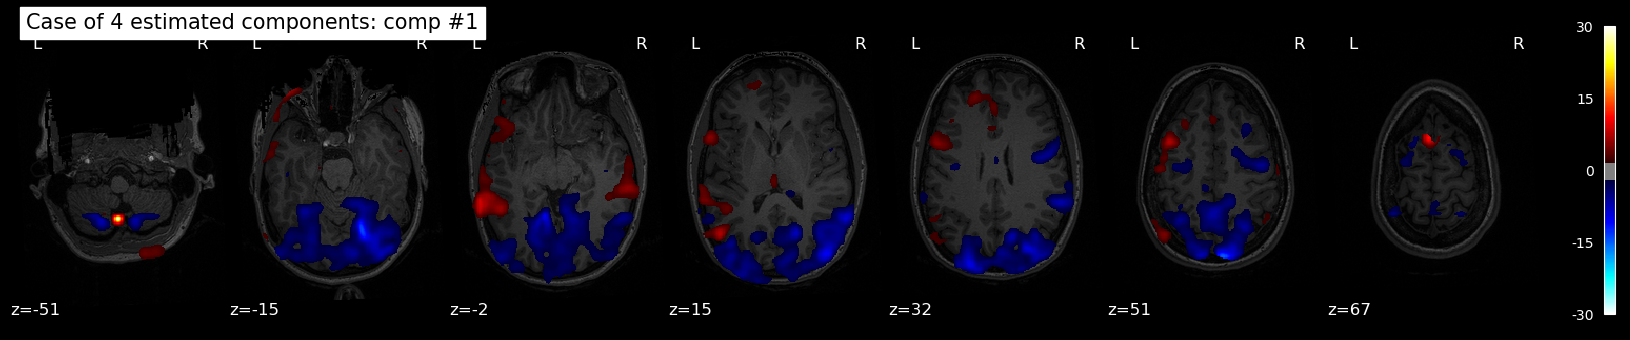

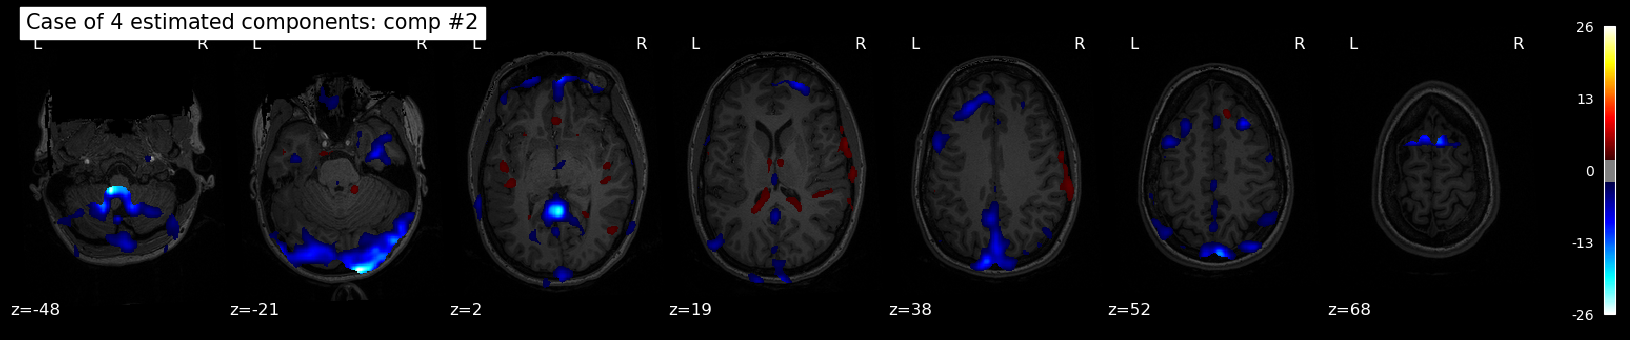

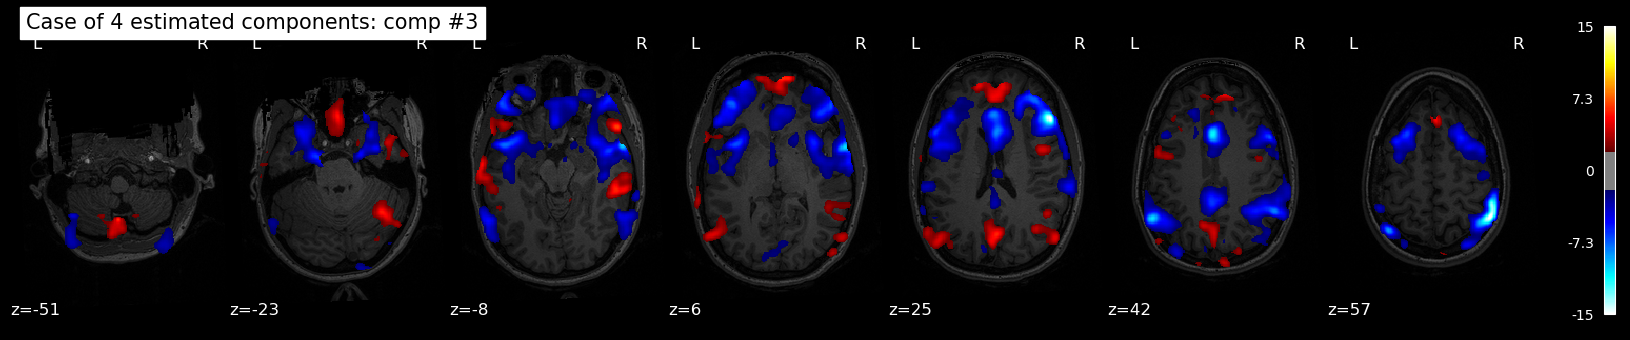

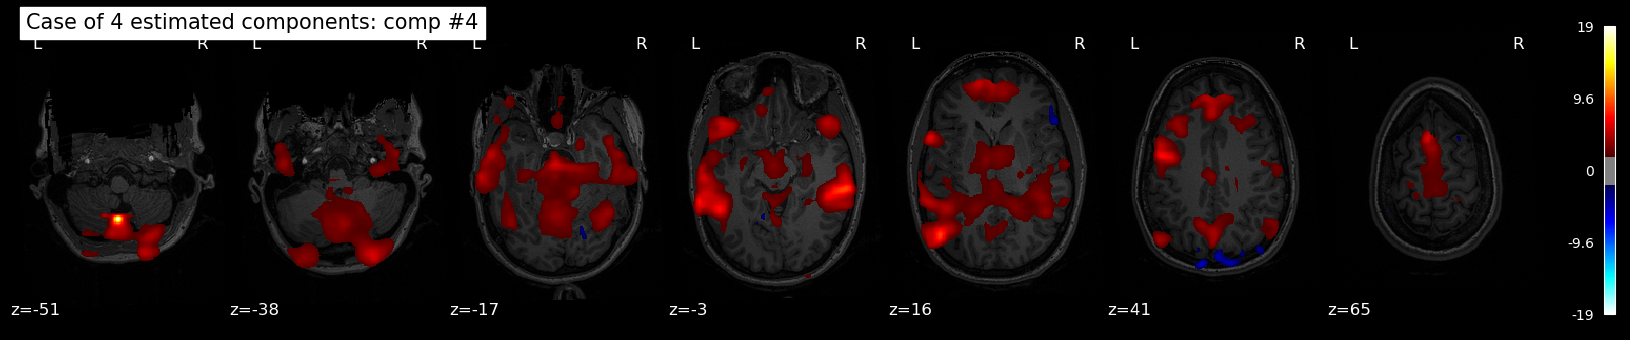

'Done all'

0

In [41]:
spatial_ICA(func_path = func_name, anat_path = anat_name, ica_comp = 4, pca = True)

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

'Running FastICA with n = 4 components'

'size H'

(271633, 1028)

'size S'

(271633, 4)

'Done ICA'

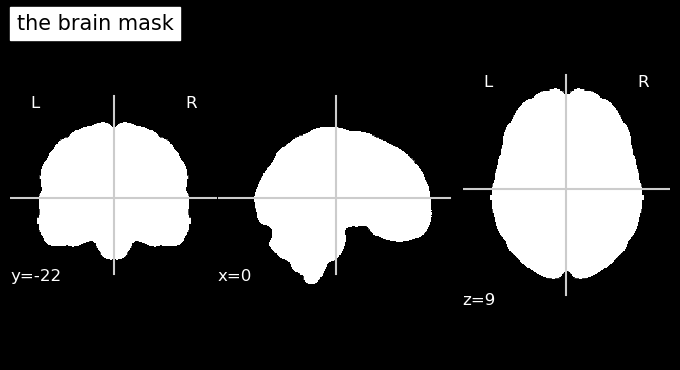

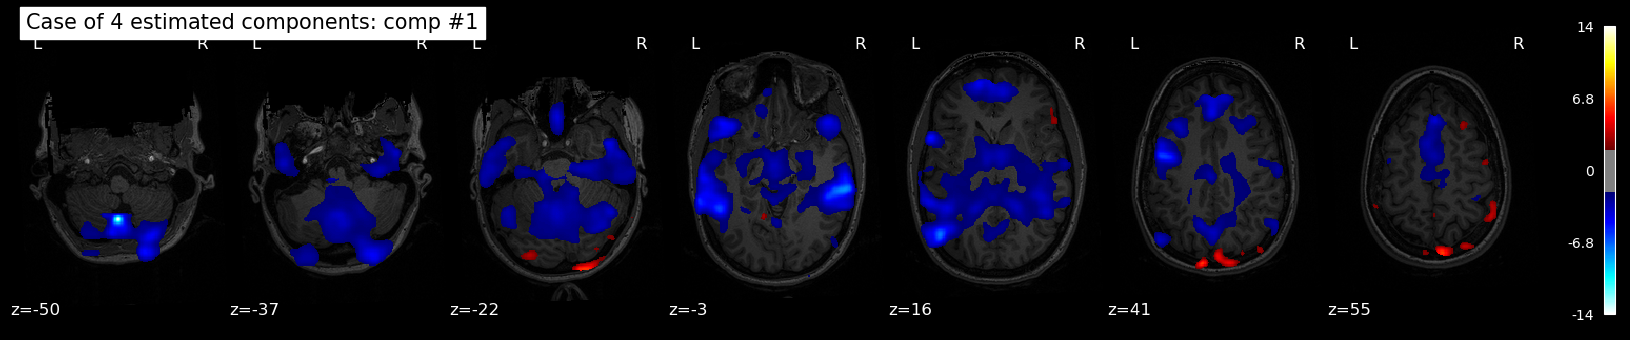

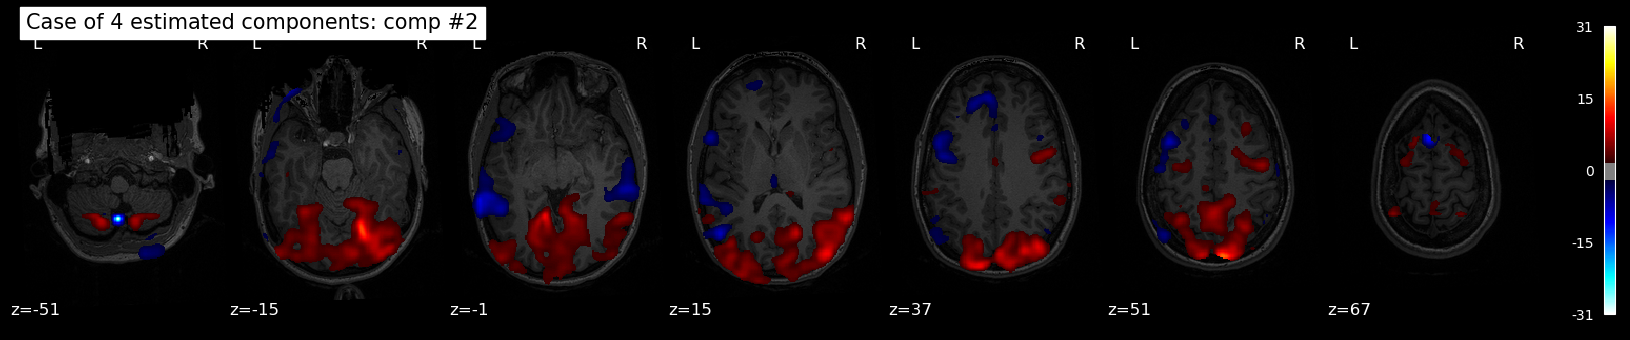

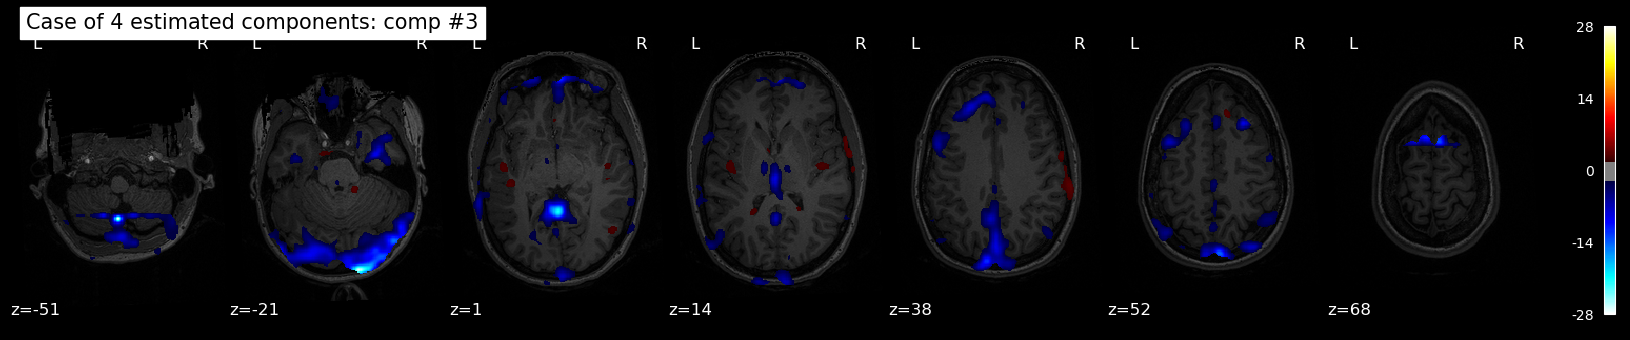

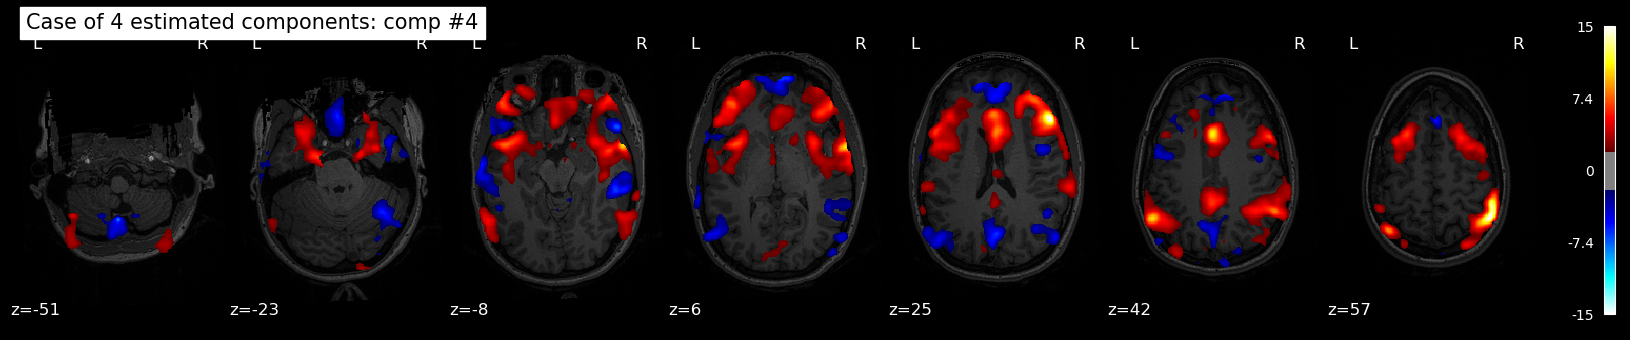

'Done all'

0

In [39]:
spatial_ICA(func_path = func_name, anat_path = anat_name, ica_comp = 4, pca = False)

### Temporal ICA

In [ ]:
#Run a temporal ICA
img = nib.load(func_name)
fdata = img.get_fdata()

nb_components =  [ica_comp,]#10]#20, 60 ...]
    
    
    for n in nb_components:

        if (pca):
            print(f"Processing component {n}")
            # run PCA as a preprocessing step for ICA with twice the number of components
            n2=2*n

            if (pca_comp is not None):
                n2 = pca_comp
            pca = PCA(n_components=n2)
            H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
            display(pca.explained_variance_ratio_, "Explained Variance = ", np.sum(pca.explained_variance_ratio_))
        else:
            H = X.T
        
        display("Running FastICA with n = %d components" %n)

        ica = FastICA(n_components=n, random_state=1, max_iter=200)
        display("size H", H.shape)
        S_ = ica.fit_transform(H)  # Get the estimated sources (S)
        display("size S", S_.shape)
        print(S_.shape)
        W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
        S_dict[n] = S_ # store the results in a dictionary
    
    display("Done Temporal ICA")

In [30]:
img = nib.Nifti1Image(np.reshape(S_dict[4][:, 0], (x,y,z)), affine)

In [ ]:
#Make function
#vary PCA no PCA and components
#look at average BOLD signal of our components 
#make brain mask for our T1 weighted image
#make atlas and make fit components to mask and fit correlation to different brain atlas areas
#temporal ICA